# Adding Discrete sets

Load main libraries, set paths and adjust plotting theme (optional)

In [1]:
from pathlib import Path
import numpy as np
import pyvista as pv
pv.set_jupyter_backend('static')
pv.global_theme.background = 'white'
pv.global_theme.color = "beige"
pv.global_theme.show_edges = True
pv.global_theme.window_size = [800, 400]

STATICS_DIR = Path("../../../../_static")
HEXBEAM_MULTIBLOCK_FILEPATH = STATICS_DIR / "hexbeam_multiblock_discrete_case_1.vtm"

### Load the Mesh

In this examples, we are simply interested in manipulating the FEB file and not the mesh itself, therefore we will be used pre-defined mesh.
If you wish to create the mesh using python, we recommend using the pyvista or the gmsh and pygmsh libraries. 

In [2]:
mb = pv.read(HEXBEAM_MULTIBLOCK_FILEPATH)
mb

MultiBlock (0x137be105880)
  N Blocks    3
  X Bounds    -2.500, 2.500
  Y Bounds    -0.500, 0.500
  Z Bounds    0.000, 1.000

Extract each block from the multiblock

In [3]:
first_block = mb["first_block"]
second_block = mb["second_block"]
selected_load_surface = mb["selected_load_surface"]

Extract the field data (just to make it easier later on)

In [4]:
first_block_discrete_ids = first_block.field_data["discrete_ids"]
second_block_discrete_ids = second_block.field_data["discrete_ids"]

first_block_ground_ids = first_block.field_data["ground_ids"]
second_block_ground_ids = second_block.field_data["ground_ids"]
second_block_boundary_ids = second_block.field_data["boundary_ids"]

load_surface_connectivity = selected_load_surface.field_data["load_surface_connectivity"]

Create lines (for visualization only)

In [5]:
src_points = first_block.points[first_block_discrete_ids]
dst_points = second_block.points[second_block_discrete_ids]
lines = np.stack((src_points, dst_points), axis=1).reshape(-1, 3)

Plot the data

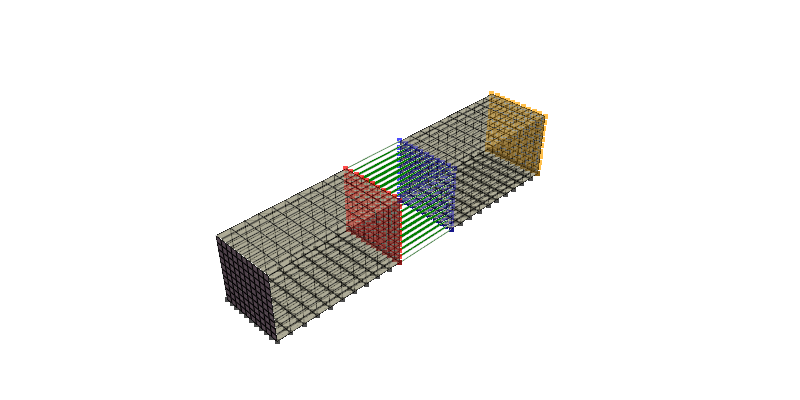

In [6]:
plotter = pv.Plotter()
plotter.add_mesh(first_block, color="beige", opacity=0.7)
plotter.add_mesh(second_block, color="beige", opacity=0.7)
plotter.add_points(first_block.points[first_block_discrete_ids], color="red", point_size=5, opacity=0.7)
plotter.add_points(second_block.points[second_block_discrete_ids], color="blue", point_size=5, opacity=0.7)
plotter.add_lines(lines, color="green", width=1)
plotter.add_points(first_block.points[first_block_ground_ids], color="black", point_size=5, opacity=0.7)
plotter.add_points(second_block.points[second_block_ground_ids], color="black", point_size=5, opacity=0.7)
plotter.add_points(second_block.points[second_block_boundary_ids], color="orange", point_size=5, opacity=0.7)
plotter.add_mesh(selected_load_surface, color="purple", point_size=6)
plotter.show()

### Create FEB

#### Create a FEB object:

In [7]:
from febio_python import Feb

feb = Feb(version=2.5)

#### Setup basic configurations:

In [8]:
feb.setup_module(module_type="solid") # default values
feb.setup_globals(T=0, R=0, Fc=0) # default values
feb.setup_controls(analysis_type="dynamic") # here, you can change basic settings. See docs for more info.
feb.setup_output(variables=["displacement", "Lagrange strain", "stress"]) # default values

#### Add materials

In [9]:
from febio_python.core import Material

# Define the block materials

# first block material
material_1 = Material(
    id=1,
    type="isotropic elastic",
    name="FirstBlockMaterial",
    parameters=dict(
        E=2e3,
        v=0.3,
        density=1,
    )
)
# second block material
material_2 = Material(
    id=2,
    type="isotropic elastic",
    name="SecondBlockMaterial",
    parameters=dict(
        E=1e3,
        v=0.25,
        density=1,
    )
)

Add the material to the FEB object

In [10]:
feb.add_materials([material_1, material_2])

#### Add mesh

In [11]:
from febio_python.core import Nodes, Elements

# Define the nodes
first_block_nodes_obj = Nodes(name="FirstBlockNodes", coordinates=first_block.points)
second_block_nodes_obj = Nodes(name="SecondBlockNodes", coordinates=second_block.points)

# Define the elements
first_block_elements = Elements(
    name="FirstBlockElements",
    type="HEXAHEDRON",
    connectivity=first_block.cells_dict[pv.CellType.HEXAHEDRON],
    mat=1
)
second_block_elements = Elements(
    name="SecondBlockElements",
    type="HEXAHEDRON",
    connectivity=second_block.cells_dict[pv.CellType.HEXAHEDRON] + first_block.n_points, # we need to offset the indices
    mat=2
)

Add the nodes and elements to the FEB object

In [12]:
feb.add_nodes([first_block_nodes_obj, second_block_nodes_obj])
feb.add_elements([first_block_elements, second_block_elements])

#### Add Nodesets

In [13]:
from febio_python.core import NodeSet

# Define the node sets
boundary_nodeset = NodeSet(
    name="BoundaryNodes",
    ids=second_block_boundary_ids + first_block.n_points  # since this is the second block, we need to offset the ids
)

first_block_ground_nodeset = NodeSet(
    name="FirstBlockGroundNodes",
    ids=first_block_ground_ids
)
second_block_ground_nodeset = NodeSet(
    name="SecondBlockGroundNodes",
    ids=second_block_ground_ids + first_block.n_points  # since this is the second block, we need to offset the ids
)

Add node sets to the FEB object

In [14]:
feb.add_node_sets([boundary_nodeset, first_block_ground_nodeset, second_block_ground_nodeset])

#### Add Surfaces

In [15]:
from febio_python.core import Surfaces

# Define the surface
surface = Surfaces(
    name="LoadSurface",
    type="QUAD",
    connectivity=load_surface_connectivity,
)

Add surface to the FEB object

In [16]:
feb.add_surfaces([surface])

#### Add loads

In [17]:
from febio_python.core import SurfaceLoad, LoadCurve

# Define the surface load
load = SurfaceLoad(
        surface="LoadSurface",  # this is the surface name (must be in the FEB object)
        load_curve=1,  # this is the load curve ID
        name="SurfaceLoad",  # optional name
        scale=-1000, # scale factor
        linear=True,  # linear pressure load
        symmetric_stiffness=True)  # symmetric stiffness matrix

# Define the load curve
lc = LoadCurve(
    id=1,
    interpolate_type="linear",
    data=np.array([[0, 0], [1, 1]]))

Add load and load curve to the FEB object

In [18]:
feb.add_surface_loads([load])
feb.add_load_curves([lc])

#### Add Boundary conditions

In [19]:
from febio_python.core import FixCondition
# create the fixed boundary condition
fixed = FixCondition(
    dof="x,y,z",  # fix only the z direction
    node_set="BoundaryNodes",
    name="Fixed")
ground_fixed_1 = FixCondition(
    dof="z",  # fix only the z direction
    node_set="FirstBlockGroundNodes",
    name="FirstBlockGroundFixed")
ground_fixed_2 = FixCondition(
    dof="z",  # fix only the z direction
    node_set="SecondBlockGroundNodes",
    name="SecondBlockGroundFixed")

Add the fixed boundary condition to the FEB object

In [20]:
feb.add_boundary_conditions([fixed, ground_fixed_1, ground_fixed_2])

#### Add Discrete Sets

##### First option:

In [21]:
from febio_python.core import DiscreteSet, DiscreteMaterial

# Create the discrete set object
discrete_set_obj = DiscreteSet(
        name="DiscreteSet",
        src=first_block_discrete_ids,
        dst=second_block_discrete_ids + first_block.n_points,  # since this is the second block, we need to offset the ids
        dmat=1)

# Create the discrete material object
discrete_material = DiscreteMaterial(
        id=1,
        type="linear spring",
        name="DiscreteMaterial",
        parameters=dict(
            E=1e6
        )
    )

Add discrete set, and discrete material to the FEB object

In [22]:
feb.add_discrete_sets([discrete_set_obj])
feb.add_discrete_materials([discrete_material])

##### Second option:

Alternatively, we can also setup discrete sets based on Nodesets. This is a convinience method from febio-python.
This is useful when we already have pre-defined nodesets or when we do not want to handle the coordinations of "node ids" directly.
Imagine a scenario in which there are multiple meshes or multiple discrete sets; it will get harder to manually track all ids and the order they appear in the mesh.
When preparing the data, we recommend creating a single mesh object, and extract all data relate to this "combined mesh" instead of manipulating ids directly, this way it will reduce chances of errors.

In [29]:
feb.clear_discrete_sets()
feb.get_discrete_sets()

[]

Define nodesets where discrete sets will be applied

In [24]:
src_ds_nodeset = NodeSet(
    name="SourceNodesForDiscreteSet",
    ids=first_block_ground_ids
)
dst_ds_nodeset = NodeSet(
    name="DestinationNodesForDiscreteSet",
    ids=second_block_ground_ids + first_block.n_points  # since this is the second block, we need to offset the ids
)

Add node sets to the FEB object

In [25]:
feb.add_node_sets([src_ds_nodeset,
                   dst_ds_nodeset])

In [26]:
# Create the discrete set object
discrete_set_obj = DiscreteSet(
        name="DiscreteSet",
        src="SourceNodesForDiscreteSet",
        dst="DestinationNodesForDiscreteSet",
        dmat=1)

In [27]:
feb.add_discrete_sets([discrete_set_obj])

### Writing FEB

In [28]:
output_file = STATICS_DIR / "sample_discrete_set_case_1.feb"
feb.write(output_file)